# MS025 Epoching
06/27/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re
import scipy
from scipy.stats import zscore

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS025'
subj_format = ['nlx']
subj_site = ['MSSM']


### Import Preprocessed Data

In [5]:
mne_data_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', preload=True)

photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

In [6]:
photodiode_data

<Raw | photodiode.fif, 1 x 1269504 (2539.0 s), ~9.7 MB, data loaded>

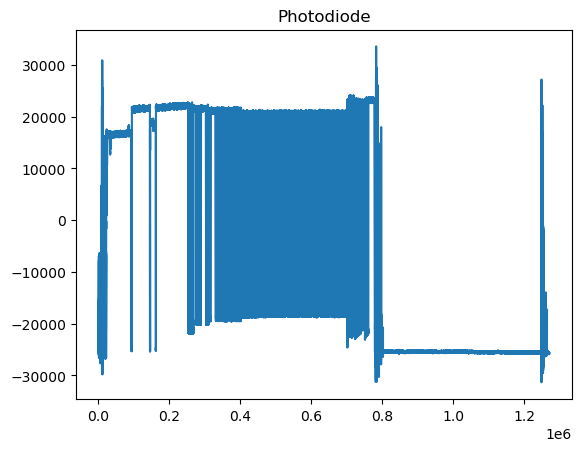

In [12]:
plt.plot(photodiode_data._data[0, :])
plt.title("Photodiode")
plt.show()

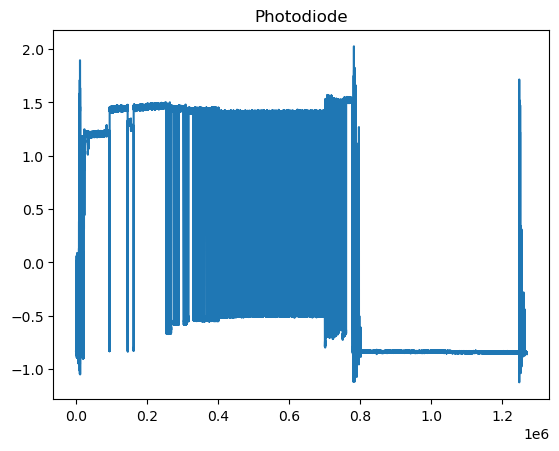

In [28]:
# Sanity check the photodiode
plt.plot(zscore(photodiode_data._data[0, :]))
plt.title("Photodiode")
plt.show()

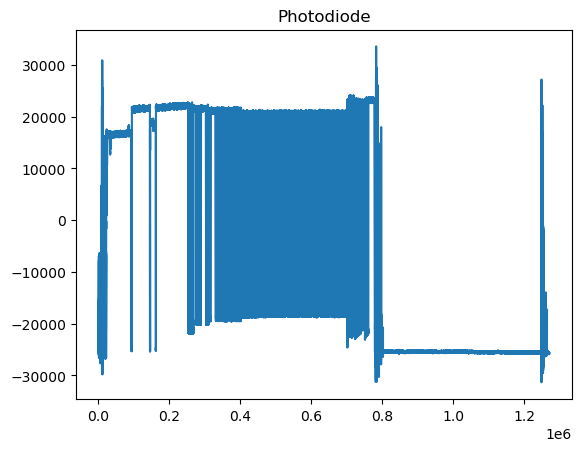

In [29]:
# Sanity check the photodiode
plt.plot(photodiode_data._data[0,])
plt.title("Photodiode")
plt.show()

### Load Anat Recon Info 


In [7]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,notes
0,LaCaS1,A32sg_L,-8.551953,47.560752,20.574440,-7.364096,42.879442,7.816402,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus F,NaN,NaN
1,LaCaS10,Unknown,-17.348071,64.346899,55.331263,-15.943065,67.827566,42.142829,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
2,LaCaS11,Unknown,-17.747895,65.545910,58.127789,-16.252304,69.749974,44.950649,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
3,LaCaS12,Unknown,-17.747895,65.945580,59.725803,-16.193126,70.554453,46.641912,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
4,LaCaS2,A32p_L,-9.751424,49.559103,24.968981,-8.600387,46.074869,12.332196,Gray,Left MSFG superior frontal gyrus medial segment,Unknown,L ACC,L CG,Left frontal pole 4 A,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,RPVNH9,mOccG_R,29.431284,-69.942282,-4.993797,29.084658,-86.459783,9.976051,White,Right Cerebral White Matter,Area hOc4lp,R Middle Occipital Gyrus,R LOcC,Right superior middle occipital gyrus D,NaN,NaN
168,uLAglT,rHipp_L,-16.148600,10.391424,-14.981390,-16.594453,-3.626931,-23.761121,Gray,Left Amygdala,Amygdala (LB),L ParaHippocampal Gyrus,L Hipp,Left parahippocampal gyrus A,Left amygdala inferior,NaN
169,uLmOlF,A11m_L,-8.951776,61.549208,-4.594294,-7.639574,50.840300,-25.038950,Gray,Left MOrG medial orbital gyrus,Area Fo1,L Superior Orbital Gyrus,L OrG,Left frontal orbital 2 B,NaN,NaN
170,uRAglT,rHipp_R,15.037636,10.391424,-14.182383,17.162481,-3.723941,-23.243948,Gray,Right Amygdala,Amygdala (LB),R ParaHippocampal Gyrus,R Hipp,Right amygdala inferior,NaN,NaN


## Load behavior

In [8]:
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,weighted_low,p_g,p_s,util_rpe,util_tcpe,util_dcpe,util_tregret,util_dregret,util_trelief,util_drelief
0,1,17.0,mix,281.191734,281.194518,284.000014,286.015234,2.805496,0.0,-0.80,...,-2.480351,0.073859,0.926141,-0.189300,-2.669651,-2.480351,-2.669651,-2.480351,0.000000,0.000000
1,2,132.0,loss,291.485670,291.494772,294.743755,296.760470,3.248982,-0.5,-0.91,...,-2.768263,0.648502,0.351498,2.768263,0.000000,3.323128,0.000000,0.000000,2.768263,3.323128
2,3,141.0,loss,301.272516,301.288089,303.006460,303.013385,1.718371,-0.6,-1.01,...,-3.025554,0.720153,0.279847,0.000000,-0.856332,-0.856332,0.000000,0.000000,-0.856332,-0.856332
3,4,56.0,gain,336.622560,336.630316,338.887292,338.895129,2.256976,0.2,0.00,...,0.000000,0.514178,0.485822,0.000000,0.253620,0.253620,0.000000,0.000000,0.253620,0.253620
4,5,73.0,gain,346.354041,346.354799,349.214847,351.231851,2.860048,0.4,0.00,...,0.000000,0.487715,0.512285,-0.413392,-0.413392,-0.457918,-0.413392,-0.457918,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,57.0,gain,2090.617402,2090.623172,2093.275802,2093.282839,2.652630,0.2,0.00,...,0.000000,0.523055,0.476945,0.000000,-0.083608,-0.083608,-0.083608,-0.083608,0.000000,0.000000
146,147,108.0,loss,2100.282703,2100.283575,2103.355231,2103.363451,3.071655,-0.2,-0.72,...,-2.267298,0.305133,0.694867,0.000000,-1.521720,-1.521720,-1.521720,-1.521720,0.000000,0.000000
147,148,78.0,gain,2117.280533,2117.281256,2121.776867,2121.784627,4.495610,0.4,0.00,...,0.000000,0.561598,0.438402,0.000000,0.457918,0.457918,0.000000,0.000000,0.457918,0.457918
148,149,65.0,gain,2128.339101,2128.339835,2132.104251,2134.121392,3.764415,0.3,0.00,...,0.000000,0.507858,0.492142,-0.386812,-0.386812,-0.358333,-0.386812,-0.358333,0.000000,0.000000


In [9]:
beh_ts = behav_df['TrialOnset']

## Photodiode alignment

In [10]:
# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, 
                                            smoothSize=11, windSize=15, height=1)

10 blocks
..........

found matches for 15 of 164 pulses


In [11]:
print(slope, offset)

1.0783549813222069 120.32854443729093


## Make epochs

In [12]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}


In [13]:

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0],
       'DecisionOnset': [0, 3.0]}

In [14]:
epochs_all_evs = {f'{x}': np.nan for x in evs}
epochs_all_baseline = {f'{x}': np.nan for x in evs}

In [15]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', 
                 elec_path=anat_file, 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, 
                 downsamp_factor=1, IED_args=IED_args)

    epochs_all_evs[event] = ev_epochs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 583 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 18292 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 19500 out of 19500 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  96 out of 130 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 18638 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 19500 out of 19500 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using ba

In [16]:
epochs_all_evs

{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~225.2 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~375.1 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add metadata to epochs

In [17]:
for event in evs.keys():

    # Let's add our behavioral events to the metadata. Substitute this with the particulars for your behavioral dataframe. 

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    event_metadata['safe'] = behav_df['SafeBet'].tolist()
    event_metadata['low'] = behav_df['LowBet'].tolist()
    event_metadata['high'] = behav_df['HighBet'].tolist()
    event_metadata['profit'] = behav_df['Profit'].tolist()
    event_metadata['outcome'] = behav_df['Outcome'].tolist()
    #model-free vars
    event_metadata['g_ev'] = behav_df['GambleEV'].tolist()
    event_metadata['cr'] = behav_df['CR'].tolist()
    event_metadata['c_ev'] = behav_df['choiceEV'].tolist()
    event_metadata['rpe'] = behav_df['RPE'].tolist()
    event_metadata['tcpe'] = behav_df['totalCPE'].tolist()
    event_metadata['dcpe'] = behav_df['decisionCPE'].tolist()
    event_metadata['tregret'] = behav_df['totalRegret'].tolist()
    event_metadata['dregret'] = behav_df['decisionRegret'].tolist()
    event_metadata['trelief'] = behav_df['totalRelief'].tolist()
    event_metadata['drelief'] = behav_df['decisionRelief'].tolist()
    event_metadata['util_g'] = behav_df['util_g'].tolist()
    event_metadata['util_s'] = behav_df['util_s'].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

In [18]:
epochs_all_evs[event].metadata

,raglt6,rhplt6,laglt4,lpvnh14,lacas12,photodiode,rcmip10,rcmip11,lpvnh12,lmcms10,...,c_ev,rpe,tcpe,dcpe,tregret,dregret,trelief,drelief,util_g,util_s
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.240,-0.560,-1.12,-0.80,-1.12,-0.80,0.00,0.00,-2.291051,0.000000
1,NaN,NaN,[1102],NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.455,0.455,0.00,0.50,0.00,0.00,0.91,0.50,-2.768263,-3.323128
2,[1774],[1774],[2134],NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.60,-0.60,0.00,0.00,0.41,0.41,-3.025554,-3.881886
3,[1210],[1209],[1208],NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.36,-0.36,0.00,0.00,0.20,0.20,0.305014,0.253620
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.400,-0.400,-0.80,-0.40,-0.80,-0.40,0.00,0.00,0.413392,0.457918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,[1557],NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.43,-0.43,-0.43,-0.43,0.00,0.00,0.337228,0.253620
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.20,-0.20,-0.20,-0.20,0.00,0.00,-2.267298,-1.521720
147,NaN,NaN,[1048],NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-1.04,-1.04,0.00,0.00,0.40,0.40,0.682278,0.457918
148,[2210],[2209],[2203],NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.370,-0.370,-0.74,-0.30,-0.74,-0.30,0.00,0.00,0.386812,0.358333


### Save epoched data

In [19]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/epoch_{event}.fif', overwrite=True)